In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.applications import ResNet50, ResNet101, VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout, Layer, MultiHeadAttention, Normalization, Flatten, Add
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.metrics import Precision, Recall
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Sabitler
TARGET_SIZE = (48, 48)
NUM_CLASSES = 10
EPOCHS = 7
BATCH_SIZE = 1024

# ----------------- VERİ ÖN İŞLEME -----------------
(x_train, y_train), (x_test, y_test) = mnist.load_data()

def preprocess_mnist(images, target_size):
    processed_images = []
    for img in images:
        img_3d = np.stack([img, img, img], axis=-1)
        resized_img = array_to_img(img_3d, data_format='channels_last').resize(target_size)
        processed_images.append(img_to_array(resized_img))

    processed_images = np.array(processed_images)
    return processed_images / 255.0

x_train_processed = preprocess_mnist(x_train, TARGET_SIZE)
x_test_processed = preprocess_mnist(x_test, TARGET_SIZE)
y_train_categorical = to_categorical(y_train, num_classes=NUM_CLASSES)
y_test_categorical = to_categorical(y_test, num_classes=NUM_CLASSES)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [2]:
# ----------------- ViT (Vision Transformer) Özel Katmanlar -----------------
class Patches(Layer):
    """Görüntüyü sabit boyutlu yamalara böler."""
    def __init__(self, patch_size):
      super().__init__()
      self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID',
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

class PatchEncoder(Layer):
    """Yamaları vektörlere gömer ve pozisyon bilgisini ekler."""
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = Dense(units=projection_dim)
        self.position_embedding = tf.keras.layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 48, 48, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 54, 54, 3) │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 24, 24,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 24, 24,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 24, 24,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 26, 26,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 12, 12,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 12, 12,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 12, 12,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 12, 12,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 12, 12,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 12, 12,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 12, 12,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 12, 12,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 12, 12,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 12, 12,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 12, 12,    │      1,024 │ conv2_block1_3_c

 Total params: 25,696,138 (98.02 MB)

 Trainable params: 2,108,426 (8.04 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/7
59/59 ━━━━━━━━━━━━━━━━━━━━ 52s 539ms/step - accuracy: 0.5893 - loss: 1.3304 - precision: 0.8562 - recall: 0.3488 - val_accuracy: 0.8842 - val_loss: 0.4182 - val_precision: 0.9412 - val_recall: 0.8181
Epoch 2/7
59/59 ━━━━━━━━━━━━━━━━━━━━ 10s 173ms/step - accuracy: 0.8806 - loss: 0.4198 - precision: 0.9356 - recall: 0.8173 - val_accuracy: 0.9199 - val_loss: 0.2787 - val_precision: 0.9507 - val_recall: 0.8840
Epoch 3/7
59/59 ━━━━━━━━━━━━━━━━━━━━ 10s 172ms/step - accuracy: 0.9157 - loss: 0.2968 - precision: 0.9474 - recall: 0.8808 - val_accuracy: 0.9361 - val_loss: 0.2187 - val_precision: 0.9591 - val_recall: 0.9150
Epoch 4/7
59/59 ━━━━━━━━━━━━━━━━━━━━ 10s 172ms/step - accuracy: 0.9333 - loss: 0.2333 - precision: 0.9547 - recall: 0.9096 - val_accuracy: 0.9455 - val_loss: 0.1885 - val_precision: 0.9645 - val_recall: 0.9290
Epoch 5/7
59/59 ━━━━━━━━━━━━━━━━━━━━ 10s 175ms/step - accuracy: 0.9365 - loss: 0.2116 - precision: 0.9553 - recall: 0.9184 - val_accuracy: 0.9491 - val_loss: 0.

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 48, 48, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 54, 54, 3) │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 24, 24,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 24, 24,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 24, 24,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 26, 26,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 12, 12,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 12, 12,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 12, 12,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 12, 12,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 12, 12,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 12, 12,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 12, 12,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 12, 12,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 12, 12,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 12, 12,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 12, 12,    │      1,024 │ conv2_block1_3_c

 Total params: 44,766,602 (170.77 MB)

 Trainable params: 2,108,426 (8.04 MB)

 Non-trainable params: 42,658,176 (162.73 MB)

Epoch 1/7
59/59 ━━━━━━━━━━━━━━━━━━━━ 53s 598ms/step - accuracy: 0.4691 - loss: 1.6507 - precision: 0.8323 - recall: 0.1478 - val_accuracy: 0.7902 - val_loss: 0.7458 - val_precision: 0.9161 - val_recall: 0.6173
Epoch 2/7
59/59 ━━━━━━━━━━━━━━━━━━━━ 18s 309ms/step - accuracy: 0.8053 - loss: 0.6747 - precision: 0.9159 - recall: 0.6670 - val_accuracy: 0.8702 - val_loss: 0.4728 - val_precision: 0.9379 - val_recall: 0.7909
Epoch 3/7
59/59 ━━━━━━━━━━━━━━━━━━━━ 18s 309ms/step - accuracy: 0.8697 - loss: 0.4653 - precision: 0.9320 - recall: 0.7969 - val_accuracy: 0.8912 - val_loss: 0.3753 - val_precision: 0.9415 - val_recall: 0.8420
Epoch 4/7
59/59 ━━━━━━━━━━━━━━━━━━━━ 18s 298ms/step - accuracy: 0.8939 - loss: 0.3713 - precision: 0.9392 - recall: 0.8462 - val_accuracy: 0.9129 - val_loss: 0.3109 - val_precision: 0.9484 - val_recall: 0.8763
Epoch 5/7
59/59 ━━━━━━━━━━━━━━━━━━━━ 17s 295ms/step - accuracy: 0.9092 - loss: 0.3140 - precision: 0.9436 - recall: 0.8719 - val_accuracy: 0.9201 - val_loss: 0.

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 48, 48, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,250,250 (58.18 MB)

 Trainable params: 535,562 (2.04 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/7
59/59 ━━━━━━━━━━━━━━━━━━━━ 75s 892ms/step - accuracy: 0.6729 - loss: 1.1873 - precision: 0.8941 - recall: 0.3653 - val_accuracy: 0.9203 - val_loss: 0.2930 - val_precision: 0.9564 - val_recall: 0.8831
Epoch 2/7
59/59 ━━━━━━━━━━━━━━━━━━━━ 20s 340ms/step - accuracy: 0.9295 - loss: 0.2593 - precision: 0.9578 - recall: 0.8978 - val_accuracy: 0.9486 - val_loss: 0.1825 - val_precision: 0.9674 - val_recall: 0.9336
Epoch 3/7
59/59 ━━━━━━━━━━━━━━━━━━━━ 20s 345ms/step - accuracy: 0.9510 - loss: 0.1736 - precision: 0.9666 - recall: 0.9342 - val_accuracy: 0.9571 - val_loss: 0.1498 - val_precision: 0.9699 - val_recall: 0.9445
Epoch 4/7
59/59 ━━━━━━━━━━━━━━━━━━━━ 20s 343ms/step - accuracy: 0.9591 - loss: 0.1389 - precision: 0.9709 - recall: 0.9477 - val_accuracy: 0.9640 - val_loss: 0.1254 - val_precision: 0.9729 - val_recall: 0.9551
Epoch 5/7
59/59 ━━━━━━━━━━━━━━━━━━━━ 20s 340ms/step - accuracy: 0.9659 - loss: 0.1170 - precision: 0.9749 - recall: 0.9570 - val_accuracy: 0.9662 - val_loss: 0.

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 48, 48, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patches (Patches)   │ (None, None, 192) │          0 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_encoder       │ (None, 36, 64)    │     14,656 │ patches[0][0]     │
│ (PatchEncoder)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 36, 64)    │        128 │ patch_encoder[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 36, 64)    │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 36, 64)    │          0 │ multi_head_atten… │
│                     │                   │            │ patch_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 36, 64)    │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2304)      │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1024)      │  2,360,320 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 10)        │     10,250 │ dense_7[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,451,850 (9.35 MB)

 Trainable params: 2,451,850 (9.35 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/7
59/59 ━━━━━━━━━━━━━━━━━━━━ 20s 185ms/step - accuracy: 0.6607 - loss: 1.5280 - precision: 0.7343 - recall: 0.6260 - val_accuracy: 0.9446 - val_loss: 0.1880 - val_precision: 0.9580 - val_recall: 0.9333
Epoch 2/7
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.9473 - loss: 0.1800 - precision: 0.9601 - recall: 0.9359 - val_accuracy: 0.9634 - val_loss: 0.1250 - val_precision: 0.9720 - val_recall: 0.9551
Epoch 3/7
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.9667 - loss: 0.1134 - precision: 0.9743 - recall: 0.9607 - val_accuracy: 0.9714 - val_loss: 0.0958 - val_precision: 0.9775 - val_recall: 0.9664
Epoch 4/7
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.9739 - loss: 0.0860 - precision: 0.9792 - recall: 0.9693 - val_accuracy: 0.9723 - val_loss: 0.0863 - val_precision: 0.9768 - val_recall: 0.9685
Epoch 5/7
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9800 - loss: 0.0677 - precision: 0.9843 - recall: 0.9769 - val_accuracy: 0.9762 - val_loss: 0.0773 - v

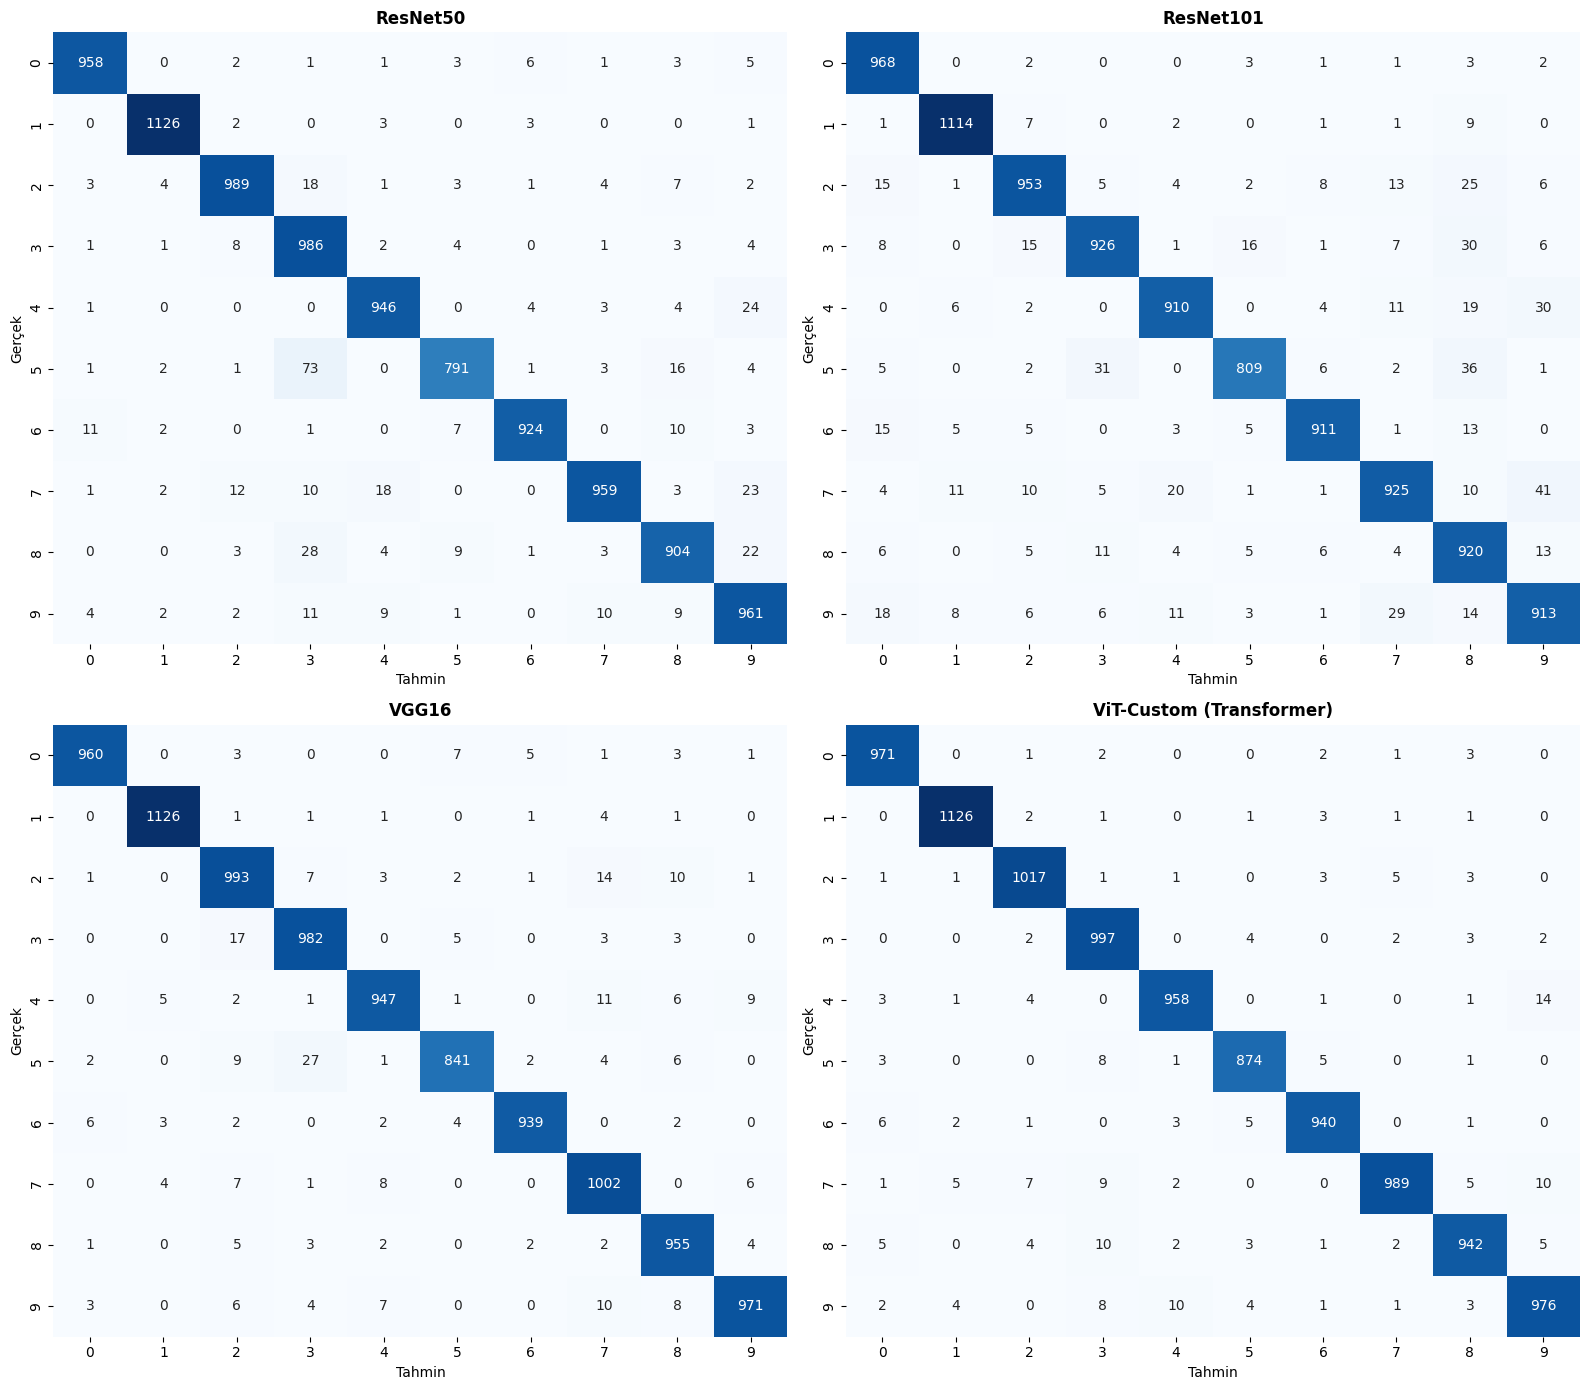

In [3]:
# Sonuçları tutacak ana liste
COMPARISON_RESULTS = []
ALL_PREDICTIONS = {}

def create_and_train_model(model_name, base_model_class=None, is_vit=False):

    input_shape = (TARGET_SIZE[0], TARGET_SIZE[1], 3)
    input_tensor = Input(shape=input_shape)

    # ----------------- MODEL MİMARİSİ -----------------
    if is_vit:
        patch_size = 8
        projection_dim = 64
        num_patches = (TARGET_SIZE[0] // patch_size) ** 2

        patches = Patches(patch_size)(input_tensor)
        encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

        x1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = MultiHeadAttention(num_heads=4, key_dim=projection_dim, dropout=0.1)(x1, x1)
        x2 = Add()([attention_output, encoded_patches])

        x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x2)
        x = tf.keras.layers.Flatten()(x)
        x = Dense(1024, activation='relu')(x)
        predictions = Dense(NUM_CLASSES, activation='softmax')(x)
        model = Model(inputs=input_tensor, outputs=predictions)

    else:
        base_model = base_model_class(weights='imagenet',
                                      include_top=False,
                                      input_tensor=input_tensor)

        for layer in base_model.layers:
            layer.trainable = False

        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(1024, activation='relu')(x)
        predictions = Dense(NUM_CLASSES, activation='softmax')(x)
        model = Model(inputs=base_model.input, outputs=predictions)

    # ----------------- EĞİTİM VE DEĞERLENDİRME -----------------
    model.summary()

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

    history = model.fit(x_train_processed, y_train_categorical,
                        epochs=EPOCHS, batch_size=BATCH_SIZE,
                        validation_data=(x_test_processed, y_test_categorical),
                        verbose=1)

    # Değerlendirme
    results = model.evaluate(x_test_processed, y_test_categorical, verbose=0)

    # F1-Score için Classification Report
    y_pred_probs = model.predict(x_test_processed, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)
    ALL_PREDICTIONS[model_name] = y_pred
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

    # Sonuçları kaydetme
    COMPARISON_RESULTS.append({
        'Model': model_name,
        'Test Doğruluğu': results[1],
        'Test Kesinliği (Avg)': results[2],
        'Test Duyarlılığı (Avg)': results[3],
        'F1-Score (Weighted Avg)': report['weighted avg']['f1-score'],
    })

# ----------------- MODELLERİ ÇALIŞTIRMA VE SONUÇ TOPLAMA -----------------
create_and_train_model("ResNet50", ResNet50)
create_and_train_model("ResNet101", ResNet101)
create_and_train_model("VGG16", VGG16)
create_and_train_model("ViT-Custom (Transformer)", is_vit=True)


# 1. COMPARISON_RESULTS listesini DataFrame'e dönüştürür.
comparison_df = pd.DataFrame(COMPARISON_RESULTS)

# 2. Doğruluk skoruna göre tabloyu sıralar.
comparison_df = comparison_df.sort_values(by='Test Doğruluğu', ascending=False)

# 3. Sonuçları temiz, düzenli bir tablo formatında ekrana basar.
print("             FARKLI MİMARİLERİN PERFORMANS KARŞILAŞTIRMASI")
# to_markdown() ile çıktı formatını düzenleriz.
print(comparison_df.to_markdown(index=False, floatfmt=".4f"))



# --- Matris Görselleştirme ---
def plot_confusion_matrices(predictions_dict, y_true):
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    axes = axes.flatten()
    model_names = list(predictions_dict.keys())

    for i, model_name in enumerate(model_names):
        if i < len(axes):
            y_pred = predictions_dict[model_name]
            cm = confusion_matrix(y_true, y_pred)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i], cbar=False)
            axes[i].set_title(f"{model_name}", fontsize=12, fontweight='bold')
            axes[i].set_xlabel("Tahmin")
            axes[i].set_ylabel("Gerçek")

    plt.tight_layout()
    plt.show()

print("\nMatrisler çiziliyor...")
plot_confusion_matrices(ALL_PREDICTIONS, y_test)
